In [1]:
%reload_ext blackcellmagic
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from qflow.wavefunctions import (
    JastrowMcMillian,
    JastrowPade,
    JastrowOrion,
    SimpleGaussian,
    WavefunctionProduct,
    FixedWavefunction,
    Dnn,
    SumPooling,
)
from qflow.wavefunctions.nn.layers import DenseLayer
from qflow.wavefunctions.nn.activations import sigmoid, tanh, relu, identity, exponential

from qflow.hamiltonians import LennardJones, HDFHE2

from qflow.samplers import BoxImportanceSampler, BoxMetropolisSampler
from qflow.optimizers import AdamOptimizer, SgdOptimizer
from qflow.training import train, EnergyCallback, SymmetryCallback, ParameterCallback
from qflow.statistics import compute_statistics_for_series
from qflow import DistanceCache

def plot_training(energies, symmetries, parameters):
    fig, (eax, sax, pax) = plt.subplots(ncols=3, figsize=(16, 4))
    eax.plot(energies, label=r"$\langle E_L\rangle$ [a.u]")
    sax.semilogx(symmetries, label=r"$S(\Psi)$")
    pax.semilogx(parameters)
    eax.legend()
    sax.legend()

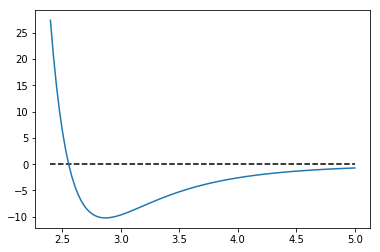

In [2]:
H = LennardJones()
x = np.linspace(2.4, 5, 100)
plt.plot(x, [H.internal_potential(np.array([[0, 0], [1, 0]])*x_) for x_ in x])
plt.hlines(0, min(x), max(x), linestyles='dashed')

In [3]:
rho = 0.0196  # Å^-3
P, D = 64, 3  # Particles, dimensions
L = (P / rho)**(1/3)
system = np.empty((P, D))
L

14.835697433860295

In [4]:
psi = JastrowMcMillian(5, 2.51)
psi_sampler = BoxMetropolisSampler(system, psi, L, 5)
s = psi_sampler.next_configuration()
np.min([np.linalg.norm(s[i]-s[j]) for i in range(P) for j in range(P) if i!=j])

3.1202677917818793

In [5]:
with DistanceCache(system, L):
    psi = JastrowMcMillian(5, 2.51)
    psi_sampler = BoxMetropolisSampler(system, psi, L, 5)
    psi_sampler.thermalize(10000)
    s = psi_sampler.next_configuration()
    print(psi_sampler.acceptance_rate)
    print(H.internal_potential(s))
    print(H.kinetic_energy(s, psi))
    print(H.local_energy(s, psi))
    print(np.min([np.linalg.norm(s[i]-s[j]) for i in range(P) for j in range(P) if i!=j]))

0.2338766123387661
-1020.5840965008332
239.29820795944104
-781.2858885413922
2.2185815880360873


In [ ]:
psi_energies = EnergyCallback(samples=5000, verbose=True)
psi_symmetries = SymmetryCallback(samples=100)
psi_parameters = ParameterCallback()

with DistanceCache(system, L):
    train(
        psi,
        H,
        psi_sampler,
        iters=15000,
        samples=1000,
        gamma=0,
        optimizer=AdamOptimizer(len(psi.parameters)),
        call_backs=(psi_energies, psi_symmetries, psi_parameters),
    )
plot_training(np.array(psi_energies)/P, psi_symmetries, psi_parameters)


EnergyCallback(iter=0): 9060569.090488505
EnergyCallback(iter=150): 9079008.54740923
EnergyCallback(iter=300): 9068357.689196607
EnergyCallback(iter=450): 9094245.557185026
EnergyCallback(iter=600): 9026552.68933872


In [7]:
psi_sampler.acceptance_rate

0.0